## State

Langgraph utilizes states as the way to pass message between nodes. There's also a handy message state called `MessagesState`, that is basically a `TypedDict` with a reducer function responsible for keep adding messages in the `message` field. Let's create a similar state, but we'll add a `user_input` field, as well as a `summary` field. The main idea here (and this is totally random) is that we'll store the user query in the `user_input` field, we'll add the messages between the nodes in the `messages` list, and we'll output on the last node a summary of everything that the graph worked, on the the `summary` field.

In [1]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_input: str
    summary: str

## Nodes

Each node is responsible for one specific action in a LangGraph graph. So we'll create some nodes to exemplify this:

1. Decide the amount of messages the `user_input` can have to tell a story about two people talking about the `user_input` query.
2. Create the talks between the two people, and add it in the `messages` field.
3. Summarize the conversation found in the `messages` field.

Of course this is only for showing how one can utilize the nodes to create a simple graph. Lather on we'll create a more usefull agent.

In [2]:
# Let's load the environment variables
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
# Let's start with the LLM and the Langgraph builder, StateGraph
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph

# Instantiate the LLM
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

# Create the graph builder
graph_builder = StateGraph(GraphState)

In [4]:
# Create the first node to decide the amount of messages
def decide_amount_of_messages(state: GraphState):
    # Clean the state variables that we'll need to use, so that we always start with a clean slate
    state['messages'] = []
    state['summary'] = ""

    # Get the user input
    user_input = state.get('user_input', '')
    if not user_input:
        raise ValueError("User input is required to decide the amount of messages.")

    # Create a system prompt to decide the amount of messages
    system_prompt = """
    You are a novel writer tasked with creating a very short store about two people talking about a given topic.
    In this part of the process, you'll need to decide how many messages the conversation will have, and only this.
    The amount of messages should be between 2 and 50, the messages should be short and capable ot telling a story about the two people talking about the given topic.
    Do not write the messages, just return the amount of messages that the conversation will have and instructions to the next node to create the messages.
    """
    human_prompt = f"""
    User input to be handled as a topic: {user_input}
    """
    prompt = [system_prompt, human_prompt]
    response = llm.invoke(prompt)
    
    # Returning only the messages, will let the LangGraph to utilize the redurecer on the 'messages' field, and it'll add the message to the state. 
    # Since this is the first node, this'll be the firt message on the list.
    return {'messages': response.content} 

# Add the node to the graph builder
graph_builder.add_node("decide_amount_of_messages", decide_amount_of_messages)

In [5]:
# Create the second node, to create the actuall message conversation.
from langchain_core.messages import AIMessage
def create_messages(state: GraphState):
    # Get the instruction from the state. It should be the first message in the list.
    instruction_message = state['messages'][0]
    user_input = state.get('user_input', '')
    if not instruction_message:
        raise ValueError("No instruction message found in the state.")
    
    # Create the system prompt to create the messages
    system_prompt = """
    You are a novel writer tasked with creating a very short store about two people talking about a given topic.
    In this part of the process, you'll need to create the messages that will be used in the conversation.
    You already have the instructions on how to create the messages, as well as the topic to be used.
    The output should be a JSON list of messages, where each message is a dictionary with the following fields:
    - talker: The name of the person talking, it can be any name you want, as long as it is consistent throughout the conversation.
    - content: The content of the message, it should be short and capable of telling a
    """
    human_prompt = f"""
    User input to be handled as a topic: {user_input}
    Instructions to create the messages: {instruction_message}
    """
    prompt = [system_prompt, human_prompt]
    # Just for kicks, let's create a dictionary output and parse this into a message list, that'll add on the state
    class TalkingMessage(TypedDict):
        talker: str
        content: str
    class Conversation(TypedDict):
        messages: list[TalkingMessage]
    
    talk_messages = []
    response = llm.with_structured_output(Conversation).invoke(prompt)

    for message in response['messages']:
        talk_messages.append(AIMessage(content=message['content'], additional_kwargs={'talker': message['talker']}))

    return {'messages': talk_messages}

# Add the node to the graph builder
graph_builder.add_node("create_messages", create_messages)

In [6]:
# Now let's add the last node, to summarize the conversation
def summarize_conversation(state: GraphState):
    # Get the messages from the state
    messages = state['messages']
    if not messages:
        raise ValueError("No messages found in the state.")
    
    # Create the system prompt to summarize the conversation
    system_prompt = """
    You are a novel writer tasked with summarizing a conversation between two people.
    In this part of the process, you'll need to summarize the conversation found in the messages.
    The output should be a short summary of the conversation, that can be used to understand what was talked about.
    Also, make the output as a Markdown text, and include the messages in it.
    """
    human_prompt = f"""
    Messages to be summarized: {messages}
    """
    prompt = [system_prompt, human_prompt]
    
    response = llm.invoke(prompt)
    
    # Add the summary to the state
    return {'summary': response.content}
# Add the node to the graph builder
graph_builder.add_node("summarize_conversation", summarize_conversation)

In [7]:
# Add the edges between the nodes
from langgraph.graph import START, END

graph_builder.add_edge(START, "decide_amount_of_messages")
graph_builder.add_edge("decide_amount_of_messages", "create_messages")
graph_builder.add_edge("create_messages", "summarize_conversation")
graph_builder.add_edge("create_messages", END)

# Compile the graph
graph = graph_builder.compile()

In [8]:
# Test user input
test_state = GraphState(
    user_input="What is the meaning of life, and why it's 42?",
    messages=[],
    summary=""
)
# Run the graph with the test state
result = graph.invoke(test_state)

In [9]:
for message in result['messages']:
    print('---')
    print(f'Content: {message.content}')
    print(f'Talker: {message.additional_kwargs.get("talker", "Unknown")}')

---
Content: A classic topic!

I've decided that the conversation will have **5 messages**.

Here are the instructions for the next node:

1. Create a conversation between two people, Alex and Maya, about the meaning of life and why it's 42.
2. Keep each message short, around 1-2 sentences.
3. The conversation should start with Alex bringing up the topic and Maya responding with a curious tone.
4. The conversation should explore the idea that 42 is the answer to the ultimate question of life, but also poke fun at the mystery surrounding it.
5. End the conversation with a thought-provoking or humorous remark.

Please proceed with creating the messages!
Talker: Unknown
---
Content: I've always wondered, what's the meaning of life? And I think I found the answer: it's 42!
Talker: Alex
---
Content: Really? 42? That's quite a random number. What's so special about it?
Talker: Maya
---
Content: Well, apparently it's the answer to the ultimate question of life, but nobody knows what the quest

In [11]:
from IPython.display import display, Markdown
display(Markdown(result['summary']))

## Conversation Summary
The conversation between Alex and Maya revolves around the meaning of life, specifically the notion that 42 is the answer to the ultimate question of life. The discussion pokes fun at the mystery surrounding 42 and the fact that the question it answers is unknown.

## Conversation
* **Alex**: I've always wondered, what's the meaning of life? And I think I found the answer: it's 42!
* **Maya**: Really? 42? That's quite a random number. What's so special about it?
* **Alex**: Well, apparently it's the answer to the ultimate question of life, but nobody knows what the question is. Isn't that just brilliant?
* **Maya**: Ha! That's both fascinating and frustrating. I mean, who comes up with a answer without a question?
* **Alex**: Exactly! It's like the universe's biggest joke. But hey, at least we have 42 to ponder over.

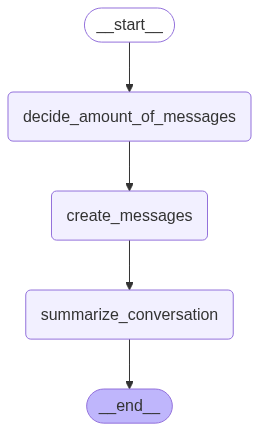

In [12]:
# It's also possible to see the graph visually, this is a neat feature of LangGraph that'll help you to understand the flow of the graph.
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

## An agent with a tool

Now that we have played a little with agents, let's create an agent that'll search the web for a specific query, and generate a summary over it.
For this we'll utilize the Tavily API, and Groq LLM with Llama.

In [13]:
# Create the Tavily search tool
from langchain_tavily import TavilySearch
search = TavilySearch(max_results=5)
tools = [search]

In [14]:
# Create an agent with the tavily search tool
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools)

In [56]:
# Now let's create the graph with the default MessagesState State, to search the web for a specific query and summarize the result.
# This should be made with 2 nodes, one to search the web, and another to summarize the result.
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage

graph_builder = StateGraph(MessagesState)

def search_node(state: MessagesState):
    # Get the user input from the state, this should always be the first messages in the state
    user_input = state['messages'][0].content if state['messages'] else None
    if not user_input:
        raise ValueError("User input is required to search the web.")
    
    # Invoke the search tool with the user input
    results = search.invoke({'query': user_input})
    if not results['results']:
        raise ValueError("No search results found.")
    # Squash the results into valid ToolMessages
    found_results = []
    for result in results['results']:
        # Create a ToolMessage for each result
        search_result = AIMessage(
            content=result['content'],
            kwargs={
                'url': result.get('url', ''),
                'title': result.get('title', '')
            }
        )
        # Add the ToolMessage to the state messages
        found_results.append(search_result)
    # Add the search results to the state
    return {'messages': found_results}

graph_builder.add_node("search", search_node)

In [57]:
# Create the node to summarize the search results
def summarize_search_results(state: MessagesState):
    # Create the system prompt to summarize the search results
    system_prompt = """
    You are a web researcher tasked with summarizing search results.
    In this part of the process, you'll need to summarize the search results found previously.
    The output should be a short summary of the search results, that can be used to understand what was found.
    Also, make the output as a Markdown text.
    Keep the URL and reference the results in the Markdown text.
    """
    human_prompt = f"""
    Search results to be summarized: {state['messages']}
    """
    prompt = [system_prompt, human_prompt]
    
    response = llm.invoke(prompt)
    
    # Add the summary to the state
    return {'messages': [response.content]}

graph_builder.add_node("summarize_search_results", summarize_search_results)

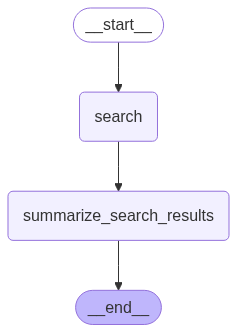

In [58]:
# Now create the edges, compile the graph, visualize it and test it
graph_builder.add_edge(START, "search")
graph_builder.add_edge("search", "summarize_search_results")
graph_builder.add_edge("summarize_search_results", END)
# Compile the graph
graph = graph_builder.compile()
# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [59]:
# Test the graph with a user input
test_state = MessagesState(messages=[AIMessage(content="Search for the meaning of life?")])
result = graph.invoke(test_state)

In [60]:
display(Markdown(result['messages'][-1].content))

**Summary of Search Results**
==========================

The search results provide various perspectives on the meaning of life, drawing from psychology, philosophy, and personal reflections. Here's a brief overview of the findings:

* **Psychological perspectives**: Researchers define meaning in life as comprising three themes: believing one's life and contributions matter, feeling that life makes sense, and actively pursuing fulfilling goals ([Greater Good Science Center](https://greatergood.berkeley.edu/article/item/three_ways_to_see_meaning_in_your_life)).
* **Philosophical views**: The meaning of life is considered a quest for significance, rather than pleasure or power ([Viktor E. Frankl, Medium](https://medium.com/@DenisBischof/search-for-meaning-in-life-based-on-viktor-e-frankl-994a72fbd700)).
* **Personal reflections**: The search for meaning in life involves exploring mystical and transpersonal experiences, as well as the role of science and mysticism ([Amazon, Search for the Meaning of Life](https://www.amazon.com/Search-Meaning-Life-Reflections-Experience/dp/076481107X)).
* **Simplified perspectives**: Some psychologists suggest that knowing one's life's meaning is related to "presence," while the drive to search for it is called "search" ([The Atlantic](https://www.theatlantic.com/family/archive/2021/10/meaning-life-macronutrients-purpose-search/620440/)).
* **Comprehensive overviews**: The Wikipedia article on the [Meaning of Life](https://en.wikipedia.org/wiki/Meaning_of_life) provides a detailed examination of the concept, including abstract objects, causality, and the nature of existence.

These search results offer a range of insights into the complex and multifaceted concept of the meaning of life.